In [1]:
#hide
from IPython.display import HTML
import matplotlib.pyplot as plt
import proplot as plot
plot.rc['figure.facecolor'] = 'white'
plot.rc['axes.grid'] = False
plot.rc['lines.markeredgewidth'] = 0
plot.rc['image.cmap'] = 'PiYG'

# Authorship identification
- toc: true 
- badges: false
- comments: true
- categories: [stylometry, machine learning, natural language processing]

Last year I was able to take a few elective courses in the grad computer science department: Data Mining in the spring semester and Intro to Machine Learning in the fall semester. It was a nice change of pace to study something different than physics. One project I worked on was to perform authorship identification using support vector machines. It was a pretty fun project, so I thought I would post the results here. The goal of the project was to reproduce the results of [this paper](https://www.researchgate.net/publication/221655968_N-Gram_Feature_Selection_for_Authorship_Identification). Reproducing someone else's results is a good thing to do because 1) it validates their research and 2) it is a chance to actively learn about a topic.

### Stylometry

#### Motivation: the Federalist Papers

The Federalist Papers are an important collection of 85 essays written by Hamilton, Madison, and Jay during 1787 and 1788. They were published under the alias "Plubious" at the time, and although it became well known that the three contributed to papers, the authorship of each individual paper was kept hidden for over a decade. It was actually in the interest Hamilton and Madison, both politicians, to keep the authorship a secret (they had both changed their position on a number of issues and didn't want their political opponents to use their old arguments against them). Days before his death, however, Hamilton allegedly wrote down who he believed to be the correct author of each essay, claiming over 60 for himself. Madison waited a number of years before publishing his own list, and in the end there were 12 essays to which both Madison and Hamilton claimed authorship. Many interesting details on the controversy can be found in a paper by [Adair](https://www.jstor.org/stable/1921883?read-now=1&seq=23#page_scan_tab_contents).

<img src=images_next/Hamilton_and_Madison.png width=550>
<figcaption>Alexander Hamilton (left) and James Madison (right). Credit: Wikipedia.</figcaption>

There are two ways we could go about resolving this dispute. The first approach is to analyze the actual *content* of the text. For example, perhaps an essay draws from a reference which only Madison was intimately familiar with, or perhaps an essay is similar to some previous work by Hamilton. This was done many times over the next 150 years, but perhaps the final word on the subject was by Adair in 1944, who concluded that Madison likely wrote all 12 essays. An alternative approach is to determine the authorship using only the words on the page, i.e., to analyze the *style* of the text. For example, maybe Madison used many more commas than Hamilton. The field of *stylometry* attempts to statistically quantify these stylistic differences. David Holmes writes the following about stylometry:
> *At its heart lies an assumption that authors have an unconscious aspect to their style, an aspect which cannot consciously be manipulated but which possesses features which are quantifiable and which may be distinctive.*

I think this a valid assumption. The question is which features best characterize the author's style and which methods are best to use in the analysis of these features. Let's go back in time a bit to the first attempts at stylometry. 

#### History

[Thomas Mendenhall](https://en.wikipedia.org/wiki/Thomas_Corwin_Mendenhall), a physicist, is considered the first to statistically analyze large literary texts. He presented the following interesting idea in an 1887 paper titled [*The Characteristic Curves of Composition*](https://www.jstor.org/stable/pdf/1764604.pdf): it is well-known that each element has a unique distribution of wavelengths in the light which it emits when it is heated; perhaps each author has a unique distribution of word lengths in the texts they have written. It's a really cool idea, and I highly recommend reading his original paper. Mendenhall tallied word lengths by hand for various books, usually in batches of 1000 words or so. Here is Fig. 2 from his paper which shows the characteristic curves for a few excerpts of *Oliver Twist*.

<img src=images_next/Mendenhall_Fig2.png width=400>
<figcaption>Distribution of word lengths in "Oliver Twist". Each curve is for a different sample of 1000 words.</figcaption>

He showed that these curves are very interesting and that they do show similarities between different works by the same author. The use of these statistics for authorship identification was left for future work. 

The next significant advance in the statistical analysis of text was made by Zipf in 1932. Zipf found an interesting relationship between an integer $k$ and the frequency $f(k)$ of the $k$th most frequent word. This is often called a *rank-frequency* relationship where $k$ is the rank. The scaling law can be written as

$$ f(k) \propto k^{-1}. \tag{1}$$

The basic idea expressed by this power law is that short words are much more frequent than large words. Surprisingly, the law holds up very well, albeit not perfectly, for most texts. *Why* this is the case is still unknown; a comprehensive review of the current state of the law can be found [here](https://link.springer.com/article/10.3758/s13423-014-0585-6). The law also shows up in other situations such as national GDP:

<img src=images_next/Cristelli_Fig1_big.png width=500>
<figcaption>Zipf’s Law for National GDPs over time, which appear to be moving toward the prediction by Zipf's Law (red line). From Ref. [1].</figcaption>

Although not directly applicable to authorship identification, the success of Zipf's Law was very encouraging and led to a flurry of new mathematical models in the following years. Stylometry had a landmark case in the 1960's when researchers used the frequency distributions of short function words — words we don't think about too much like "upon" or "therefore" — to support Adair's conclusion that Madison wrote the 12 disputed Federalist Papers. 

At the end of the day, however, models created in the spirit of Zipf's Law are probably doomed to fail. The "true" underlying model must be very complex due to its dependence on human psychology. There are now many algorithms available which instead build predictive models directly from data, and these can be readily applied to the problem of authorship identification. Here we focus on the use of the Support Vector Machine (SVM).

### Support Vector Machine (SVM)

I include here the basic idea behind the SVM approach. There are, of course, a huge number of resources which go into the details [include the references]. I'll just follow the Wikipedia page since it has a nice short summary.

#### Maximum margin hyperplane

Consider a linear, binary classifier, i.e., a plane which splits the data into two classes. The equation for a plane in any number of dimensions is 

$$ y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0 = 0 \tag{2}. $$

This plane is called the *decision surface*; points are assigned to class 1 if $y(\mathbf{x}) > 0$ or class 2 when $y(\mathbf{x}) < 0$. Suppose the data is linearly separable (able to be completely split in two) and that we've found a plane which correctly splits the data. We could then scale the coordinates such that all points with $y(\mathbf{x}) \ge 1$ belong to class 1 and all points with $y(\mathbf{x}) \le -1$ belong to class 2. The separating plane then sits in the middle as in the following figure.

<img src=images_next/svm.png width=300>
<figcaption>Maximum margin separating plane. Credit: Wikipedia.</figcaption>

Notice that the plane could be rotated while still correctly splitting the existing data; the SVM attempts to find the optimal plane by maximizing the orthogonal distance from the decision plane to the closest point. This is known as the *margin*, and it can be shown that it is inversely proportional to the magnitude of $\mathbf{w}$. Thus, the SVM tries to minimize $|\mathbf{w}|^2$ subject to the constraint that all points are correctly categorized. New data is then assigned based on this optimal boundary.

Many datasets won't be linear separable. In this case there are two options for the SVM. The first is to add a penalty function in order to minimize the number of miscategorized points, so for *N* samples we minimize

$$ \frac{1}{2}|\mathbf{w}|^2 +  C\sum_{i=1}^{N}{\Theta\left[{t_i y(\mathbf{x}_i)}\right]} . \tag{3}$$

where $t_i$ is the true class of point $i$, $\Theta$ is the Heaviside step function, and $C$ is a positive constant. Let's try this on some toy data. The Python package [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) has a user-friendly interface for the SVM implementation in [LIBLINEAR](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) which we use here.

In [2]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import proplot as plot
import plotly.graph_objects as go

To do: add legend class1/2.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


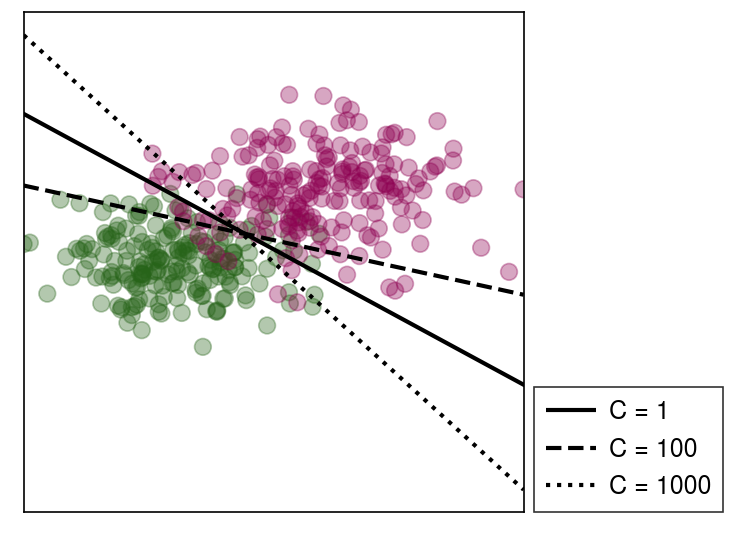

In [5]:

# Create two overlapping Gaussian distributions
np.random.seed(0)
n = 200
X = np.vstack([np.random.normal(size=(n, 2), loc=[0, 0], scale=2.0),
               np.random.normal(size=(n, 2), loc=[5, 5], scale=2.5)])
y = n * [1] + n * [-1] 

# Plot the data
fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], alpha=0.35, c=y)

# Plot decision boundary for different values of C
C_vals = [1, 100, 1000]
line_x = np.array([min(X[:, 0]), max(X[:, 0])])
for C, ls in zip(C_vals, ['solid', 'dashed', 'dotted']):
    clf = svm.LinearSVC(C=C)
    clf.fit(X, y)
    (w1, w2), w0 = clf.coef_[0], clf.intercept_
    line_y = -(w1 / w2) * line_x - (w0 / w2)
    ax.plot(line_x, line_y, c='k', ls=ls)
ax.legend(labels=['C = {}'.format(C) for C in C_vals], ncols=1, loc=(1.02, 0))
ax.format(xticks=[], yticks=[], xlim=line_x);

The three lines have significantly different angles, but all have around the same classification accuracy on the existing data. It can therefore be important to try at least a few different values of $C$ and observe the effect on the testing data classification accuracy. $C$ is known as a *hyperparameter* since it isn't changed by the algorithm during the training process, but is instead a property of the algorithm itself.

#### Kernel trick

In some cases the linear model is going to be bad, such as for the following "target" dataset.

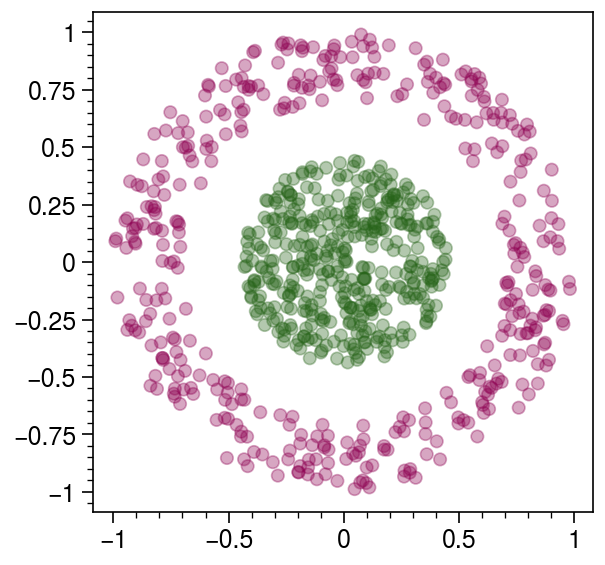

In [6]:
n = 400
r1 = np.sqrt(np.random.uniform(0.0, 0.2, size=(n,)))
r2 = np.sqrt(np.random.uniform(0.5, 1.0, size=(n,)))
t1 = np.random.uniform(0, 2*np.pi, size=(n,))
t2 = np.random.uniform(0, 2*np.pi, size=(n,))
X = np.vstack([np.vstack([r1*np.cos(t1), r1*np.sin(t1)]).T,
               np.vstack([r2*np.cos(t2), r2*np.sin(t2)]).T])
y = n * [1] + n * [-1]

fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y);

Obviously a line won't work, and ideally we would draw a circle around the inner cluster to split the data. A really cool strategy is the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method), which performs a transformation to a higher dimensional space in which the data is linearly separable. For example, consider the transformation

$$ (x_1, x_2) \rightarrow (x_1, x_2, x_1^2 + x_2^2) . \tag{4}$$

In [29]:
x1, x2 = X.T
x3 = x1**2 + x2**2
fig = go.Figure(data=go.Scatter3d(x=x1, y=x2, z=x3, mode='markers', 
                                  marker=dict(color=y, size=5, opacity=0.5)))
HTML(fig.to_html(include_plotlyjs='cdn'))

We can now split the data with a 2D plane! This isn't necessarily the transformation used by the SVM; in fact, many transformations can be used. Anyhow, the projection of a successful decision boundary will encircle the green points. A quick way to plot this boundary is to make a prediction on a grid of points which covers the entire plot range as follows.

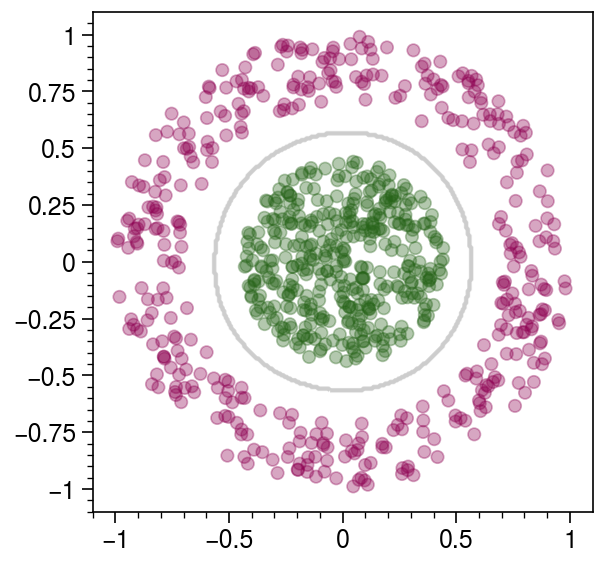

In [30]:
clf = svm.SVC()
clf.fit(X, y)

xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 300), np.linspace(-1.1, 1.1, 300))
Z = np.c_[xx.ravel(), yy.ravel()]
y_pred = clf.predict(Z)
zz = y_pred.reshape(xx.shape)

fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)
ax.contour(xx, yy, zz, alpha=0.05, cmap='binary');

There are, however, several advantages to the linear SVM. First, it is much faster to train, and second, the kernel trick may be unnecessary for high-dimensional data. As we'll see, the latter applies to the task of authorship identification.

#### Multi-class 

The two-class problem can be extended to multi-class problems. One way is to  

### Reuters 50/50 dataset

#### Dataset description

#### Feature extraction 

#### Feature selection

#### Results

### Conclusion

I think what I'll try next is to identify artists from images of their paintings.